In [18]:
import numpy as np
import matplotlib.pyplot as plt
import cProfile

# import sys
# sys.path.append('../')
# from alphastar import *



In [19]:
import numpy as np

NODE_STATE_INDEX = 0
NODE_G_INDEX = 1
NODE_H_INDEX = 2
NODE_PARENT_INDEX = 3
NODE_ACTION_INDEX = 4


class __OpenSet:

    def __init__(self, threshold):
        self.diff_threshold = np.array(threshold)
        self.points = np.empty([0, threshold.shape[0]])
        self.nodes = []

    def append(self, node):
        self.nodes.append(node)
        self.points = np.append(self.points, np.atleast_2d(node[NODE_STATE_INDEX]), axis=0)

    def contains(self, node):
        diffs = np.abs(self.points - node[NODE_STATE_INDEX])
        comps = diffs <= self.diff_threshold
        if np.any(np.logical_and.reduce(comps, axis=1)):
            return True
        return False

    def pop(self, i):
        node = self.nodes.pop(i)
        np.delete(self.points, i)
        return node

    def __len__(self):
        return len(self.nodes)


class __CloseSet:

    def __init__(self, threshold):
        self.diff_threshold = np.array(threshold)

        self.points = np.empty([0, threshold.shape[0]])
        self.nodes = []

    def append(self, node):
        self.nodes.append(node)
        self.points = np.append(self.points, np.atleast_2d(node[NODE_STATE_INDEX]), axis=0)

    def contains(self, node):
        diffs = np.abs(self.points - node[NODE_STATE_INDEX])
        comps = diffs <= self.diff_threshold
        if np.any(np.logical_and.reduce(comps, axis=1)):
            return True
        return False


def solve(start_state, goal_state, h_func, next_actions_func, state_similarity=None, g_func=None, is_end_state_func=None,
          next_states_func=None, max_iters=1000):

    def node(state, parent, action=None):  # !
        # node tuple: state, g, h, parent, action
        if parent is not None:
            p_state, p_g, p_h, p_parent, p_action = parent
        else:
            p_state, p_g, p_h, p_parent = state, 0., 0., None
        return state, g_func(state, p_state) + p_g, h_func(state, goal_state), parent, action

    start_state = np.array(start_state)
    goal_state = np.array(goal_state)

    if g_func is None:
        g_func = lambda x, y: np.linalg.norm(x - y)

    if is_end_state_func is None:
        is_end_state_func = lambda x: np.all(np.abs(x - goal_state) <= state_similarity)

    if next_states_func is None:
        next_states_func = lambda s, a: s + a

    if state_similarity is None:
        state_similarity = np.zeros(start_state.shape)
    state_len = len(start_state)

    assert state_len == len(goal_state)

    assert state_similarity is not None
    if isinstance(state_similarity, float) or isinstance(state_similarity, int):
        state_similarity = np.ones(state_len) * state_similarity

    start = node(start_state, None)

    open_set = __OpenSet(state_similarity)
    close_set = __CloseSet(state_similarity)

    open_set.append(start)

    iters = 0

    num_nodes_searched = 0

    while len(open_set) > 0:
        fs = [node[NODE_G_INDEX] + node[NODE_H_INDEX] for node in open_set.nodes]  # !
        lowest_f_index = np.argmin(fs)

        current = open_set.pop(lowest_f_index)
        num_nodes_searched += 1

        close_set.append(current)
        if is_end_state_func(current[NODE_STATE_INDEX]):
            return current, num_nodes_searched, open_set.nodes, close_set.nodes

        next_actions = next_actions_func(current[NODE_STATE_INDEX])
        next_states = next_states_func(current[NODE_STATE_INDEX], next_actions)
        for state, action in zip(next_states, next_actions):

            successor = node(state, current, action)
            if close_set.contains(successor):
                continue

            if not open_set.contains(successor):  # !
                open_set.append(successor)

        if max_iters <= 0 and iters < max_iters:
            break
        iters += 1

    return start, num_nodes_searched, open_set.nodes, close_set.nodes


def path(result):
    states, actions = [], []
    current = result
    while current is not None:
        states.append(current[NODE_STATE_INDEX])
        actions.append(current[NODE_ACTION_INDEX])

        current = current[NODE_PARENT_INDEX]

    states.reverse()
    actions.reverse()
    return states, actions


In [20]:
maze_str1 = """+++++++++++++++++++++++++
+...........+...+.......+
+..+++..++.+++.++.+.++..+
+.......+...........+...+
+++.+.+++.+++.+.+...+++.+
+...+...........+.......+
+..++++.+..+++.++..+++..+
+.......+...+...+...+...+
+.++++.++.+.+.+.+++.+.+.+
+...+...+...+.......+...+
+.+.++..++..+++.+...+++++
+.......+.......+.......+
+++++.+.+.+++..++..++.+.+
+...+.+.....+...+...+...+
+.+.+.+++.+.+.+.++.++++.+
+...+...+...+...+.......+
+.+++++.++.+++..+.++++..+
+.......+...........+...+
+.+++++.+.+.+++.+++.+.+++
+...+...........+.......+
+.+++.++++.+++.++..+++..+
+.......+...+...........+
+E+++++++++++++++++++++++"""

maze_str2 = """+++++++++++++++++++++++++
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+E+++++++++++++++++++++++"""

maze_str3 = """+++++++++++++++++++++++++
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+++.....................+
+E+++++++++++++++++++++++"""





In [21]:
class MazeWrapper:
    
    def __init__(self, maze):
        self.table = [list(line) for line in maze.splitlines()]
        self.maze = ''.join([''.join(row) for row in self.table])
        self.width, self.height = len(self.table[0]), len(self.table)
        
    def get_maze_string(self):
        res = '\n'.join([''.join(row) for row in self.table])
        return res
    
    def clone(self):
        return MazeWrapper(self.get_maze_string())
    
    def get_pos_of(self, char):
        inds = np.where([c==char for c in self.maze])[0]
        return np.array([np.array([i%self.width, i//self.width]) for i in inds])

    def plot(self):
#         plt.figure(figsize=(3, 3))


        walls = self.get_pos_of('+')
        if len(walls):
            plt.scatter(walls[:, 0], walls[:, 1], c='m', marker='s')
        
        

        end = self.get_pos_of('E')
        if len(end):
            plt.scatter(end[:, 0], end[:, 1], c='r')

        nothings = self.get_pos_of('.')
        if len(nothings):
            plt.scatter(nothings[:, 0], nothings[:, 1], c='black', marker='s') 

        open_set = self.get_pos_of('o')
        if len(open_set):
            plt.scatter(open_set[:, 0], open_set[:, 1], c='y', marker='s') 

        close_set = self.get_pos_of('c')
        if len(close_set):
            plt.scatter(close_set[:, 0], close_set[:, 1], c='gray', marker='s') 

        path = self.get_pos_of('p')
        if len(path):
            plt.scatter(path[:, 0], path[:, 1], c='b', marker='s') 
            
        start = self.get_pos_of('S')
        if len(start):
            plt.scatter(start[:, 0], start[:, 1], c='g', marker='s')

        plt.gca().invert_yaxis()
#         plt.show()
        
    def valid_directions(self, at_point):
        at_point = np.array(at_point)
        dir_vectors = np.array([[-1, 0], [0, -1], [1, 0], [0, 1], [-1, -1], [1, 1], [1, -1], [-1, 1]])
        next_states = dir_vectors+at_point
        res = [self.table[y][x] for x, y in next_states]
        return np.array([dir_vectors[i] for i, v in enumerate(res) if v=='.' or v=='E'])
    
    def replace_points_with(self, points, char):
        for x, y in points:
            self.table[y][x] = char
        self.maze = ''.join([''.join(row) for row in self.table])


In [23]:
def solve_maze(maze, start, max_iters=1000):
    start = np.array(start)
    goal = maze.get_pos_of('E')[0]
    g_func = lambda state, p_state: np.linalg.norm(state-p_state)
#     g_func = lambda state, p_state: 1
    h_func = lambda state, g_state: np.linalg.norm(state-g_state)
#     h_func = lambda state, g_state: np.sum(np.abs(state-g_state))
    is_end_state_func = lambda state: np.all(state == goal)
    next_actions_func = lambda state: maze.valid_directions(state)
    next_states_func = lambda state, actions: state+actions
    state_similarity = np.array([0.5, 0.5])
    return solve(start, goal, h_func, next_actions_func, max_iters=max_iters,
                g_func=g_func, is_end_state_func=is_end_state_func,
                next_states_func=next_states_func, state_similarity=state_similarity)
#     return solve(start, goal, h_func, next_actions_func, max_iters=max_iters
    


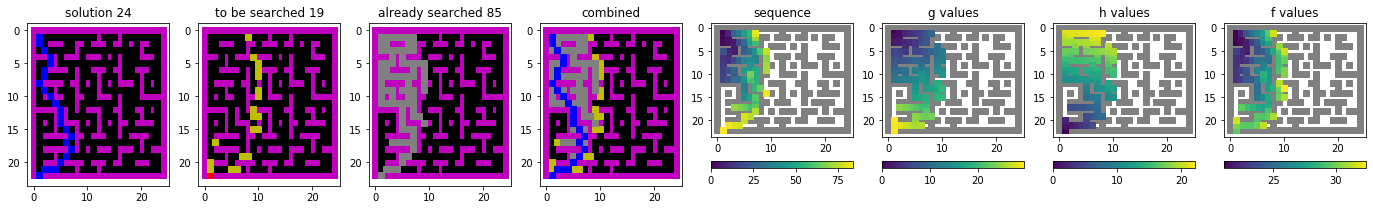

map dims: w 25, h 23
numbers ofnodes to be searched 19
numbers ofnodes searched 85
total numbers of accesible nodes 311
path length 24
path over searched 0.2823529411764706 search over all 0.2733118971061093 path over all 0.07717041800643087


(0.2823529411764706, 0.2733118971061093, 0.07717041800643087)

In [24]:
def test_optimality(maze_str, start):
    subplots = 8
    maze = MazeWrapper(maze_str)
    result, n, open_set, close_set = solve_maze(maze, start)
    states, actions = path(result)
    
    n_path = len(states)
    n_unsearched = len(open_set)
    n_searched = len(close_set)
    
    plt.figure(figsize=(3*subplots, 3))
    plt.tight_layout()
    plt.subplot(1, subplots, 1)
    plt.title(f"solution {n_path}")
    solution_maze = maze.clone()
    solution_maze.replace_points_with(states, 'p')
    solution_maze.plot()
    
    plt.subplot(1, subplots, 2)
    plt.title(f"to be searched {n_unsearched}")
    states = np.array([node[0] for node in open_set])
    open_set_maze = maze.clone()
    open_set_maze.replace_points_with(states, 'o')
    open_set_maze.plot()
    
    plt.subplot(1, subplots, 3)
    plt.title(f"already searched {n_searched}")
    states = np.array([node[0] for node in close_set])
    close_set_maze = maze.clone()
    close_set_maze.replace_points_with(states, 'c')
    close_set_maze.plot()
    
    plt.subplot(1, subplots, 4)
    plt.title("combined")
    combined = close_set_maze.clone()
    combined.replace_points_with(np.array([node[0] for node in open_set]), 'o')
    states, actions = path(result)
    combined.replace_points_with(states, 'p')
    combined.plot()
    
    plt.subplot(1, subplots, 5)
    plt.title("sequence")
    states = np.array([node[0] for node in close_set])
    seq = np.array([i for i, state in enumerate(states)])
    walls = maze.get_pos_of('+')
    plt.scatter(walls[:, 0], walls[:, 1], c='gray', marker='s')
    plt.scatter(states[:, 0], states[:, 1], c=seq, marker='s')
    plt.gca().invert_yaxis()
    plt.colorbar(orientation='horizontal')
    
    plt.subplot(1, subplots, 6)
    plt.title("g values")
    states = np.array([node[0] for node in close_set+open_set])
    gs = np.array([node[1] for node in close_set+open_set])
    walls = maze.get_pos_of('+')
    plt.scatter(walls[:, 0], walls[:, 1], c='gray', marker='s')
    plt.scatter(states[:, 0], states[:, 1], c=gs, marker='s')
    plt.gca().invert_yaxis()
    plt.colorbar(orientation='horizontal')
    
    plt.subplot(1, subplots, 7)
    plt.title("h values")
    states = np.array([node[0] for node in close_set+open_set])
    hs = np.array([node[2] for node in close_set+open_set])
    walls = maze.get_pos_of('+')
    plt.scatter(walls[:, 0], walls[:, 1], c='gray', marker='s')
    plt.scatter(states[:, 0], states[:, 1], c=hs, marker='s')
    plt.gca().invert_yaxis()
    plt.colorbar(orientation='horizontal')
    
    plt.subplot(1, subplots, 8)
    plt.title("f values")
    states = np.array([node[0] for node in close_set+open_set])
    fs = np.array([node[1]+node[2] for node in close_set+open_set])
    walls = maze.get_pos_of('+')
    plt.scatter(walls[:, 0], walls[:, 1], c='gray', marker='s')
    plt.scatter(states[:, 0], states[:, 1], c=fs, marker='s')
    plt.gca().invert_yaxis()
    plt.colorbar(orientation='horizontal')
    
    plt.show()
    
    
    n_all = len(maze.get_pos_of('.'))
    print(f"map dims: w {maze.width}, h {maze.height}")
    print('numbers ofnodes to be searched', n_unsearched)
    print('numbers ofnodes searched', n_searched)
    print('total numbers of accesible nodes', n_all)
    print('path length', n_path)
    searched_over_all = n_searched/n_all
    path_over_all = n_path/n_all
    path_over_searched = n_path/n_searched
    print('path over searched', path_over_searched, 'search over all', searched_over_all, 'path over all', path_over_all)
    return path_over_searched, searched_over_all, path_over_all
test_optimality(maze_str1, [1, 1])

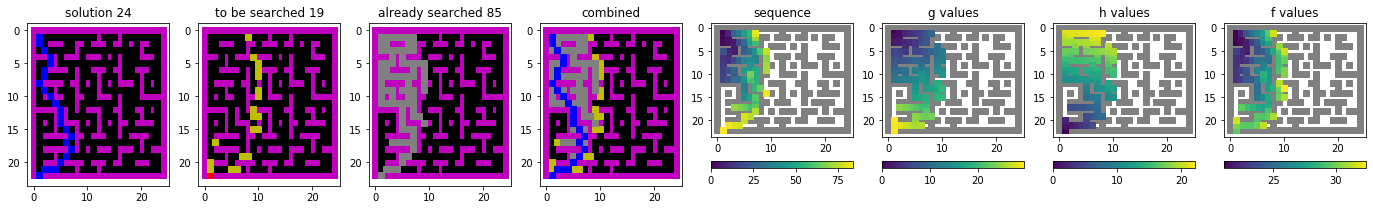

map dims: w 25, h 23
numbers ofnodes to be searched 19
numbers ofnodes searched 85
total numbers of accesible nodes 311
path length 24
path over searched 0.2823529411764706 search over all 0.2733118971061093 path over all 0.07717041800643087


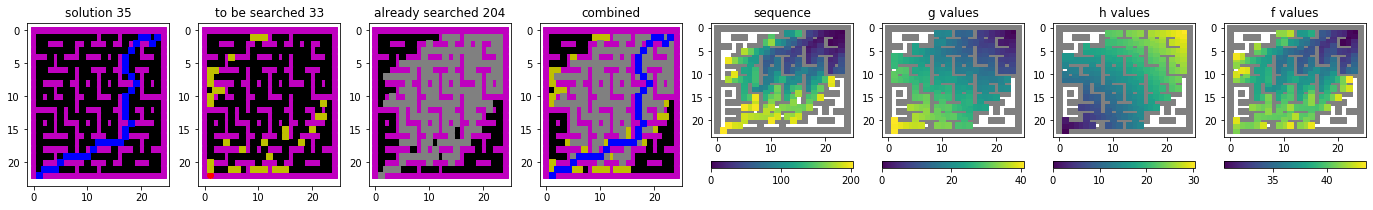

map dims: w 25, h 23
numbers ofnodes to be searched 33
numbers ofnodes searched 204
total numbers of accesible nodes 311
path length 35
path over searched 0.1715686274509804 search over all 0.6559485530546624 path over all 0.11254019292604502


(0.1715686274509804, 0.6559485530546624, 0.11254019292604502)

In [25]:
test_optimality(maze_str1, [1, 1])
test_optimality(maze_str1, [23, 1])

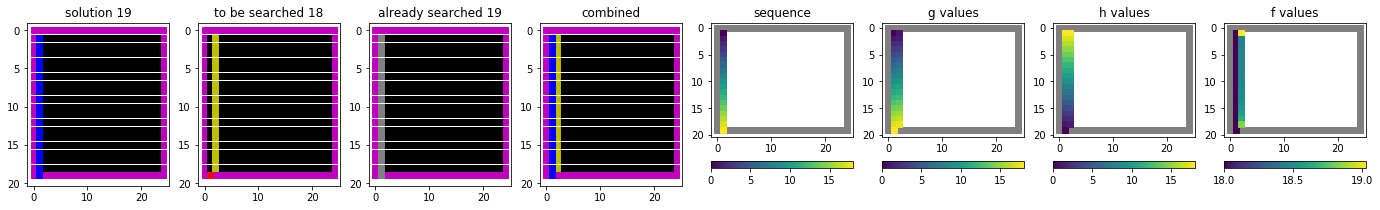

map dims: w 25, h 20
numbers ofnodes to be searched 18
numbers ofnodes searched 19
total numbers of accesible nodes 414
path length 19
path over searched 1.0 search over all 0.04589371980676329 path over all 0.04589371980676329


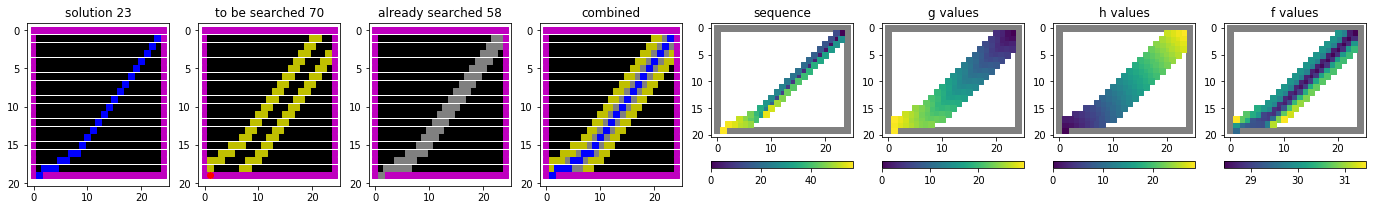

map dims: w 25, h 20
numbers ofnodes to be searched 70
numbers ofnodes searched 58
total numbers of accesible nodes 414
path length 23
path over searched 0.39655172413793105 search over all 0.14009661835748793 path over all 0.05555555555555555


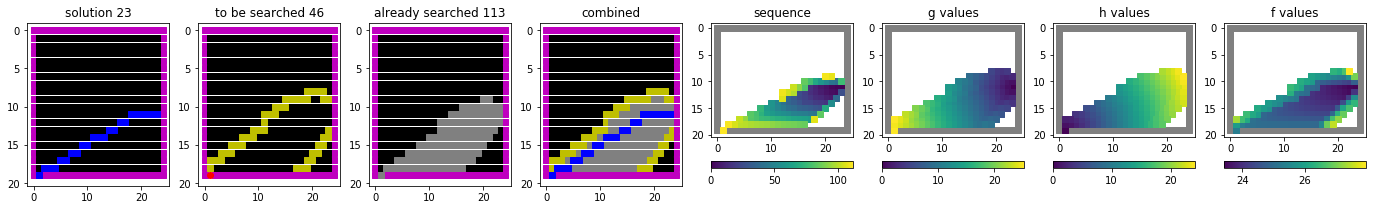

map dims: w 25, h 20
numbers ofnodes to be searched 46
numbers ofnodes searched 113
total numbers of accesible nodes 414
path length 23
path over searched 0.20353982300884957 search over all 0.27294685990338163 path over all 0.05555555555555555


(0.20353982300884957, 0.27294685990338163, 0.05555555555555555)

In [26]:
test_optimality(maze_str2, [1, 1])
test_optimality(maze_str2, [23, 1])
test_optimality(maze_str2, [23, 11])

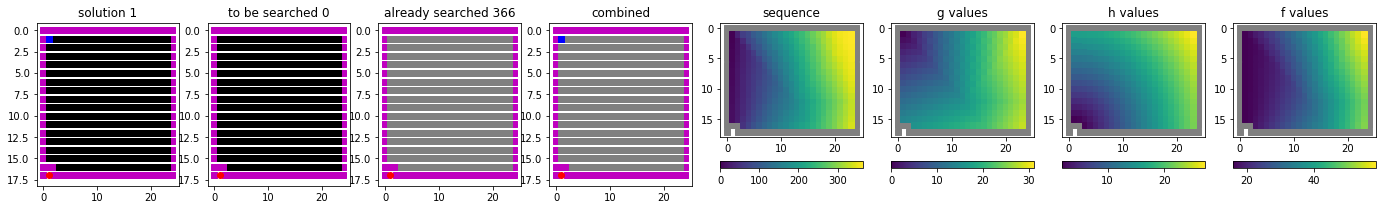

map dims: w 25, h 18
numbers ofnodes to be searched 0
numbers ofnodes searched 366
total numbers of accesible nodes 366
path length 1
path over searched 0.00273224043715847 search over all 1.0 path over all 0.00273224043715847


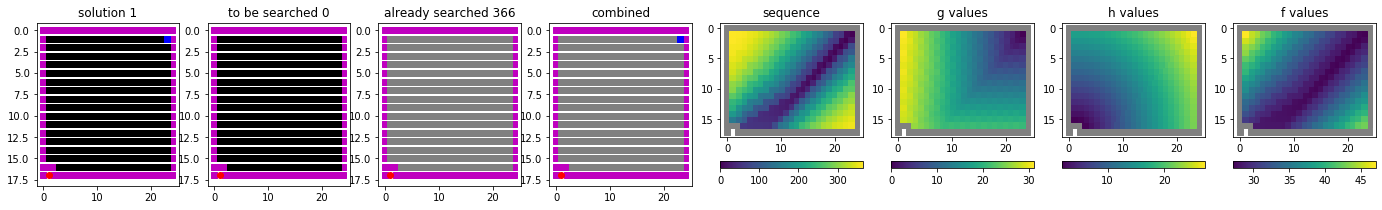

map dims: w 25, h 18
numbers ofnodes to be searched 0
numbers ofnodes searched 366
total numbers of accesible nodes 366
path length 1
path over searched 0.00273224043715847 search over all 1.0 path over all 0.00273224043715847


(0.00273224043715847, 1.0, 0.00273224043715847)

In [27]:
test_optimality(maze_str3, [1, 1])
test_optimality(maze_str3, [23, 1])

In [28]:
import time
def test_performance(maze_str):
    maze = MazeWrapper(maze_str)
    starts = maze.get_pos_of('.')
    times = []
    for i, start in enumerate(starts):
        now = time.perf_counter()
        result, n, open_set, close_set = solve_maze(maze, start)
        elapsed = time.perf_counter()-now
        print(f'{i}: solve for {start} took {elapsed} seconds')
        times.append(elapsed)
    times = np.array(times)
    total = times.sum()
    print(f'total time:{total} seconds for {len(times)} searches')
    walls = maze.get_pos_of('+')
    plt.figure(figsize=(4, 3))
    plt.scatter(walls[:, 0], walls[:, 1], c='gray', marker='s')
    plt.scatter(starts[:, 0], starts[:, 1], c=times, marker='s')
    plt.gca().invert_yaxis()
    plt.colorbar()
    
    return total, starts, times

0: solve for [1 1] took 0.022988400000031106 seconds
1: solve for [2 1] took 0.02215099999989434 seconds
2: solve for [3 1] took 0.02170099999989361 seconds
3: solve for [4 1] took 0.023779600000125356 seconds
4: solve for [5 1] took 0.023839399999815214 seconds
5: solve for [6 1] took 0.023921900000004825 seconds
6: solve for [7 1] took 0.028072399999928166 seconds
7: solve for [8 1] took 0.03256040000019311 seconds
8: solve for [9 1] took 0.03309599999988677 seconds
9: solve for [10  1] took 0.03175790000000234 seconds
10: solve for [11  1] took 0.030856900000117093 seconds
11: solve for [13  1] took 0.03904889999989791 seconds
12: solve for [14  1] took 0.03943309999999656 seconds
13: solve for [15  1] took 0.03304359999992812 seconds
14: solve for [17  1] took 0.042295199999898614 seconds
15: solve for [18  1] took 0.04318229999989853 seconds
16: solve for [19  1] took 0.04872309999996105 seconds
17: solve for [20  1] took 0.058291599999847676 seconds
18: solve for [21  1] took 0.0

154: solve for [ 6 11] took 0.00906940000004397 seconds
155: solve for [ 7 11] took 0.011087599999882514 seconds
156: solve for [ 9 11] took 0.009502000000111366 seconds
157: solve for [10 11] took 0.01069269999993594 seconds
158: solve for [11 11] took 0.012296800000058283 seconds
159: solve for [12 11] took 0.012144300000045405 seconds
160: solve for [13 11] took 0.015758500000174536 seconds
161: solve for [14 11] took 0.01391709999984414 seconds
162: solve for [15 11] took 0.01395449999995435 seconds
163: solve for [17 11] took 0.019981599999937316 seconds
164: solve for [18 11] took 0.02020889999994324 seconds
165: solve for [19 11] took 0.01882009999985712 seconds
166: solve for [20 11] took 0.019329599999991842 seconds
167: solve for [21 11] took 0.01627579999990303 seconds
168: solve for [22 11] took 0.022066400000085196 seconds
169: solve for [23 11] took 0.01833030000011604 seconds
170: solve for [ 5 12] took 0.0075785999999880005 seconds
171: solve for [ 7 12] took 0.02117670

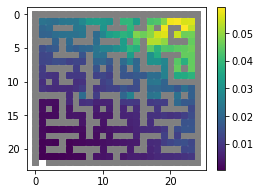

In [29]:
total, starts, times = test_performance(maze_str1)

0: solve for [1 1] took 0.006371100000023944 seconds
1: solve for [2 1] took 0.013874600000008286 seconds
2: solve for [3 1] took 0.022053799999866897 seconds
3: solve for [4 1] took 0.026732299999821407 seconds
4: solve for [5 1] took 0.030958999999938897 seconds
5: solve for [6 1] took 0.03336270000022523 seconds
6: solve for [7 1] took 0.03536589999998796 seconds
7: solve for [8 1] took 0.029149000000188607 seconds
8: solve for [9 1] took 0.038434999999935826 seconds
9: solve for [10  1] took 0.033687799999825074 seconds
10: solve for [11  1] took 0.031215199999905963 seconds
11: solve for [12  1] took 0.029738599999973303 seconds
12: solve for [13  1] took 0.02670010000019829 seconds
13: solve for [14  1] took 0.021743199999946228 seconds
14: solve for [15  1] took 0.021740199999840115 seconds
15: solve for [16  1] took 0.021069499999839536 seconds
16: solve for [17  1] took 0.023353300000053423 seconds
17: solve for [18  1] took 0.017036099999813814 seconds
18: solve for [19  1] t

153: solve for [16  7] took 0.016338899999936984 seconds
154: solve for [17  7] took 0.01765279999995073 seconds
155: solve for [18  7] took 0.019329699999843797 seconds
156: solve for [19  7] took 0.02436760000000504 seconds
157: solve for [20  7] took 0.029530000000022483 seconds
158: solve for [21  7] took 0.03354450000006182 seconds
159: solve for [22  7] took 0.03646129999992809 seconds
160: solve for [23  7] took 0.03966289999993933 seconds
161: solve for [1 8] took 0.00416640000003099 seconds
162: solve for [2 8] took 0.007659300000113944 seconds
163: solve for [3 8] took 0.011001099999930375 seconds
164: solve for [4 8] took 0.013433600000098522 seconds
165: solve for [5 8] took 0.014557399999830523 seconds
166: solve for [6 8] took 0.01370919999999387 seconds
167: solve for [7 8] took 0.01244090000000142 seconds
168: solve for [8 8] took 0.011699700000008306 seconds
169: solve for [9 8] took 0.01252969999995912 seconds
170: solve for [10  8] took 0.009795700000040597 seconds
1

308: solve for [10 14] took 0.007903100000021368 seconds
309: solve for [11 14] took 0.008877799999936542 seconds
310: solve for [12 14] took 0.011297700000113764 seconds
311: solve for [13 14] took 0.013826800000060757 seconds
312: solve for [14 14] took 0.014278500000045824 seconds
313: solve for [15 14] took 0.01818520000006174 seconds
314: solve for [16 14] took 0.021291200000177923 seconds
315: solve for [17 14] took 0.023371399999859932 seconds
316: solve for [18 14] took 0.02615460000015446 seconds
317: solve for [19 14] took 0.02871629999981451 seconds
318: solve for [20 14] took 0.0313704999998663 seconds
319: solve for [21 14] took 0.0342160000000149 seconds
320: solve for [22 14] took 0.036259900000004563 seconds
321: solve for [23 14] took 0.03813019999984135 seconds
322: solve for [ 1 15] took 0.0014461999999184627 seconds
323: solve for [ 2 15] took 0.0026649999999790452 seconds
324: solve for [ 3 15] took 0.00274730000001 seconds
325: solve for [ 4 15] took 0.00301790000

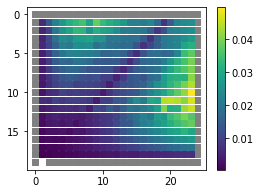

In [30]:
total, starts, times = test_performance(maze_str2)

0: solve for [1 1] took 0.15264700000011544 seconds
1: solve for [2 1] took 0.15402869999979885 seconds
2: solve for [3 1] took 0.13792540000008557 seconds
3: solve for [4 1] took 0.15240579999999682 seconds
4: solve for [5 1] took 0.13468250000005355 seconds
5: solve for [6 1] took 0.15274700000009034 seconds
6: solve for [7 1] took 0.1549552000001313 seconds
7: solve for [8 1] took 0.15385549999996329 seconds
8: solve for [9 1] took 0.15537200000017037 seconds
9: solve for [10  1] took 0.15420450000010533 seconds
10: solve for [11  1] took 0.15633989999992082 seconds
11: solve for [12  1] took 0.1271814000001541 seconds
12: solve for [13  1] took 0.15704889999983607 seconds
13: solve for [14  1] took 0.15688900000009198 seconds
14: solve for [15  1] took 0.15830750000009175 seconds
15: solve for [16  1] took 0.15759109999999055 seconds
16: solve for [17  1] took 0.1423110999999153 seconds
17: solve for [18  1] took 0.1280405999998493 seconds
18: solve for [19  1] took 0.1590936000000

152: solve for [15  7] took 0.14161719999992783 seconds
153: solve for [16  7] took 0.12642060000007405 seconds
154: solve for [17  7] took 0.15893700000015087 seconds
155: solve for [18  7] took 0.15712119999989227 seconds
156: solve for [19  7] took 0.15720329999999194 seconds
157: solve for [20  7] took 0.15664030000016282 seconds
158: solve for [21  7] took 0.13778639999986808 seconds
159: solve for [22  7] took 0.1430680000000848 seconds
160: solve for [23  7] took 0.13929639999992105 seconds
161: solve for [1 8] took 0.15317740000000413 seconds
162: solve for [2 8] took 0.1329452999998466 seconds
163: solve for [3 8] took 0.12428069999987201 seconds
164: solve for [4 8] took 0.15325579999989714 seconds
165: solve for [5 8] took 0.15346539999995912 seconds
166: solve for [6 8] took 0.12642380000011144 seconds
167: solve for [7 8] took 0.13128770000002987 seconds
168: solve for [8 8] took 0.1375665000000481 seconds
169: solve for [9 8] took 0.15411770000014258 seconds
170: solve fo

300: solve for [ 2 14] took 0.15503679999983433 seconds
301: solve for [ 3 14] took 0.1359148000001369 seconds
302: solve for [ 4 14] took 0.15399630000001707 seconds
303: solve for [ 5 14] took 0.15321250000010878 seconds
304: solve for [ 6 14] took 0.1585803999998916 seconds
305: solve for [ 7 14] took 0.1553338999999596 seconds
306: solve for [ 8 14] took 0.15531449999980396 seconds
307: solve for [ 9 14] took 0.15647730000000593 seconds
308: solve for [10 14] took 0.1342463000000862 seconds
309: solve for [11 14] took 0.15389140000002044 seconds
310: solve for [12 14] took 0.15449249999983294 seconds
311: solve for [13 14] took 0.1555956999998216 seconds
312: solve for [14 14] took 0.15609790000007706 seconds
313: solve for [15 14] took 0.15835569999990184 seconds
314: solve for [16 14] took 0.13856760000021495 seconds
315: solve for [17 14] took 0.15618829999993977 seconds
316: solve for [18 14] took 0.15622110000003886 seconds
317: solve for [19 14] took 0.15701780000017607 secon

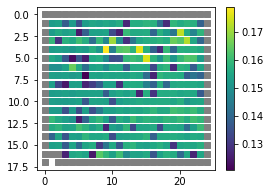

In [31]:
total, starts, times = test_performance(maze_str3)

In [32]:
maze = MazeWrapper(maze_str1)
starts = maze.get_pos_of('.')
print(cProfile.run('[solve_maze(maze, start) for start in starts]'))

         5974126 function calls (5731132 primitive calls) in 6.444 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    20939    0.013    0.000    0.131    0.000 <__array_function__ internals>:2(all)
   135237    0.083    0.000    0.684    0.000 <__array_function__ internals>:2(any)
    48529    0.030    0.000    0.299    0.000 <__array_function__ internals>:2(append)
    20939    0.013    0.000    0.246    0.000 <__array_function__ internals>:2(argmin)
    48529    0.029    0.000    0.191    0.000 <__array_function__ internals>:2(atleast_2d)
    48529    0.029    0.000    0.175    0.000 <__array_function__ internals>:2(concatenate)
    20939    0.014    0.000    0.353    0.000 <__array_function__ internals>:2(delete)
   173526    0.092    0.000    0.318    0.000 <__array_function__ internals>:2(dot)
   173526    0.096    0.000    1.608    0.000 <__array_function__ internals>:2(norm)
      311    0.000    0.000    0.009    0

In [33]:
maze = MazeWrapper(maze_str2)
starts = maze.get_pos_of('.')
print(cProfile.run('[solve_maze(maze, start) for start in starts]'))

         7430923 function calls (7124470 primitive calls) in 7.481 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    16698    0.010    0.000    0.105    0.000 <__array_function__ internals>:2(all)
   196320    0.113    0.000    0.943    0.000 <__array_function__ internals>:2(any)
    48111    0.030    0.000    0.292    0.000 <__array_function__ internals>:2(append)
    16698    0.011    0.000    0.219    0.000 <__array_function__ internals>:2(argmin)
    48111    0.028    0.000    0.191    0.000 <__array_function__ internals>:2(atleast_2d)
    48111    0.028    0.000    0.169    0.000 <__array_function__ internals>:2(concatenate)
    16698    0.011    0.000    0.287    0.000 <__array_function__ internals>:2(delete)
   241644    0.120    0.000    0.411    0.000 <__array_function__ internals>:2(dot)
   241644    0.128    0.000    2.102    0.000 <__array_function__ internals>:2(norm)
      414    0.000    0.000    0.008    0

In [34]:
maze = MazeWrapper(maze_str3)
starts = maze.get_pos_of('.')
print(cProfile.run('[solve_maze(maze, start) for start in starts]'))

         56998652 function calls (54619286 primitive calls) in 62.371 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   133956    0.084    0.000    0.829    0.000 <__array_function__ internals>:2(all)
  1482300    0.877    0.000    7.238    0.000 <__array_function__ internals>:2(any)
   267912    0.175    0.000    1.717    0.000 <__array_function__ internals>:2(append)
   133956    0.084    0.000    1.703    0.000 <__array_function__ internals>:2(argmin)
   267912    0.165    0.000    1.102    0.000 <__array_function__ internals>:2(atleast_2d)
   267912    0.163    0.000    0.998    0.000 <__array_function__ internals>:2(concatenate)
   133956    0.086    0.000    2.271    0.000 <__array_function__ internals>:2(delete)
  1977132    1.039    0.000    3.438    0.000 <__array_function__ internals>:2(dot)
  1977132    1.070    0.000   17.531    0.000 <__array_function__ internals>:2(norm)
      366    0.000    0.000    0.007  